In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

from data import pipeline
from data.window import SlidingWindow

# Data preparation

In [2]:
X_train, Y_train, X_test, Y_test = pipeline.load("LSTM") # load / buildAndSave / build

Loading LSTM dataset
Done!


In [3]:
print(X_train.shape)
print(Y_train.shape)

(1027718, 4, 8)
(1027718, 1)


In [4]:
from sklearn.preprocessing import StandardScaler

X_train = X_train.reshape(-1, 32)
X_test = X_test.reshape(-1, 32)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train.reshape(-1, 1))
print(Y_train.shape)

(1027718, 1)


In [5]:
X_train = X_train.reshape(-1, 4, 8)
X_test = X_test.reshape(-1, 4, 8)

# Training

In [6]:
batch, window, features = X_train.shape

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [8]:
model.fit(X_train, Y_train)

32117/32117 [==============================] - 68s 2ms/step - loss: 0.0673


In [9]:
from sklearn.metrics import mean_squared_error

print('Train MSE : %.3f'%mean_squared_error(Y_train, model.predict(X_train)))

32117/32117 [==============================] - 36s 1ms/step
Train MSE : 0.053


# Evaluation

In [23]:
sw = SlidingWindow(X_test)

In [25]:
pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=2)
Y_preds = [pred]

1/1 - 0s - 18ms/epoch - 18ms/step


In [13]:
last_progression = 0
print(0, '%')
while sw.next(pred): # iterator: t-1
    pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=0) # iterator: t
    Y_preds.append(pred)
        
    progression = (sw.it+1) / len(X_test) * 100
    if progression - last_progression > 1 and not int(progression) % 10:
        print(int(progression), '%')
        last_progression = progression

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
100 %


In [16]:
Y_preds = np.array(Y_preds)

In [17]:
Y_preds = sc_y.inverse_transform(Y_preds.reshape(1, -1))
Y_preds = Y_preds.reshape(-1)

In [18]:
Y_preds

array([ 3.7236362,  5.5946765,  7.4173236, ...,  2.2656589,  5.4561744,
       22.623304 ], dtype=float32)

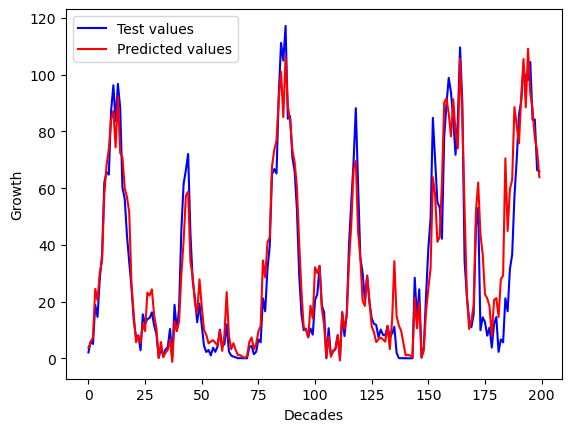

In [19]:
Y_preds = Y_preds.reshape(-1)
plt.plot(np.arange(len(Y_preds[:200])), Y_test[:200], color="blue", label= "Test values")
plt.plot(np.arange(len(Y_preds[:200])), Y_preds[:200], color="red", label= "Predicted values")
plt.xlabel("Decades")
plt.ylabel("Growth")
plt.legend()
plt.show()

In [22]:
print('Test MSE  : %.3f'%mean_squared_error(Y_test, Y_preds))

Test MSE  : 120.729
